# Electronic Medical Record(EMR) Handling Practice: MIMIC-IV

MIMIC-IV is a real world EMR relational database of intensive care unit(ICU) patients from Beth Israle Medical Centor in Boston, USA.

Real world EMR has numerous noises and complex structure which hinders analysis.

In this practice, we will deal with basic preprocessing schemes and introductory machine learning model construction.

In [1]:
# loading python modules and set configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from warnings import simplefilter
from functools import partial
from tqdm import tqdm

pd.set_option('display.max_columns', None)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.DtypeWarning)

plt.style.use('seaborn-whitegrid')
cmap_name = 'plasma'

C:\Users\USER\AppData\Local\Temp\ipykernel_20868\3692037764.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# loading all datasets
'''
정보의 source가 병원전체인지 중환자실인지로 나눌 수 있음
1. 병원전체로부터 수집되는 데이터셋: static_info, hosp_diag, hosp_med, hosp_test
2. 중환자실로부터 수집되는 데이터셋: icu_DLV, icu_med, icu_proc

The source of the data can be divided into two types: entire hospital or ICU Only
1. Dataset collected from the entire hospital stay: static_info, hosp_diag, hosp_med, hosp_test
2. Dataset collected from the ICU: icu_DLV, icu_med, icu_proc
'''
static_info = pd.read_csv('static_information.csv')
icu_DLV = pd.read_csv('icu_demo-lab-vital.csv')
icu_med = pd.read_csv('icu_medication.csv')
icu_proc = pd.read_csv('icu_procedure.csv')
hosp_diag = pd.read_csv('hosp_diagnosis.csv')
hosp_med = pd.read_csv('hosp_medication.csv')
hosp_test = pd.read_csv('hosp_test.csv')

In [3]:
# MIMIC-IV에는 다양한 item이 존재하고, 각 item은 itemid로 코딩되어 있어 정보를 이해하기 위해서는 itemid에 연결된 item을 알아야함
# 이번 실습에서는 아래의 딕셔너리에 포함된 itemid를 포함하는 식별자들을 활용할 예정임

# MIMIC-IV contains various items and each item is encoded as an itemid
# In order to understand the database, we need to be able to match each itemid to the corresponding item
# We can use the following dictonary that connects each item to its itemid

query_dict = {
    'pao2': [220224],
    'fio2': [223835],
    'gcs': [220739, 223900, 223901], # eye, verbal, motor
    'lactate': [225668],
    'vasopressor': [221289, 221662, 221653, 221906, 221749, 229630, 229632, 222315],
    'ventilator': [225792, 225794],
    'weight': [224639],
    'height': [226707, 226730],
    'heart_rate': [220045],
    'resp_rate': [224690, 220210],
    'temperature': [223761, 223762],
    'sbp': [220050, 225309, 220179],
    'dbp': [220051, 225310 , 220180],
    'bilirubin': [225690],
    'creatinine': [220615],
    'platelets': [227457],
    'blood_culture': [225401, 225437, 70011, 70012],
    'antibiotic_id': [225798, 225837, 225838, 225840, 225842, 225843, 225844, 225845, 225847, 225848, 225850, 225851, 225853,
                      225855, 225857, 225859, 225860, 225862, 225863, 225865, 225866, 225868, 225869, 225871, 225873, 225875,
                      225876, 225877, 225879, 225881, 225882, 225883, 225884, 225885, 225886, 225888, 225889, 225890, 225892,
                      225893, 225895, 225896, 225897, 225898, 225899, 225900, 225902, 225903, 225905, 227691, 228003, 229059, 229061, 229064, 229587],
    'antibiotic_name': ['amikacin', 'gentamicin', 'kanamycin', 'netilmicin', 'tobramycin', 'paromomycin', 'spectinomycin', 'geldanamycin',
                        'ertapenem', 'doripenem', 'imipenem', 'meropenem', 'cefadroxil', 'cefalexin', 'cefaclor', 'cefoxitin', 'cefprozil',
                        'cefamandole', 'cefuroxime', 'cefixime', 'cefotaxime', 'cefpodoxime', 'ceftazidime', 'ceftriaxone', 'cefepime',
                        'vancomycin', 'vanc', 'clindamycin', 'daptomycin', 'azithromycin', 'clarithromycin', 'erythromycin', 'telithromycin',
                        'aztreonam', 'nitrofurantoin', 'linezolid', 'amoxicillin', 'ampicillin', 'dicloxacillin', 'flucloxacillin',
                        'methicillin', 'nafcillin', 'oxacillin', 'penicillin', 'piperacillin', 'cefotetan', 'ticarcillin', 'timentin',
                        'colistin', 'bactrim', 'polymyxin', 'ciprofloxacin', 'gatifloxacin', 'levofloxacin', 'moxifloxacin', 'nalidixic acid',
                        'norfloxacin', 'ofloxacin', 'trovafloxacin', 'sulfadiazine', 'sulfamethoxazole', 'trimethoprim', 'TMP', 'doxycycline', 'minocycline',
                        'tetracycline', 'dapsone', 'ethambutol', 'isoniazid', 'pyrazinamide', 'rifampicin', 'rifampin', 'rifabutin', 'streptomycin',
                        'chloramphenicol', 'synercid', 'fosfomycin', 'metronidazole', 'mupirocin', 'quinupristin', 'tigecycline', 'unasyn']
}

itemid_mapping = {}
for item in list(query_dict.keys()):
    itemids = query_dict[item]

    if item == 'antibiotic_name':
        continue

    for ii in itemids:
        if item == 'gcs':
            if ii == 220739:
                itemid_mapping[ii] = item+'_eye'
            elif ii == 223900:
                itemid_mapping[ii] = item+'_verbal'
            elif ii == 223901:
                itemid_mapping[ii] = item+'_motor'

        elif item == 'antibiotic_id':
            itemid_mapping[ii] = 'antibiotic'

        else:
            itemid_mapping[ii] = item

items = list(set([i if not i.__contains__('antibiotic') else 'antibiotic' for i in query_dict.keys()]))

## 1. Exploratory Data Analysis

### 1.1 data overview

In [4]:
'''
static_information.csv
환자의 기본적인 시간에 따라 변하지 않는 정보가 기록된 데이터셋

data description
stay_id, hadm_id, subject_id: 중환자실 입원, 병원 입원, 환자 식별자
intime, outtime: 중환자실 입/퇴원 시각
admittime, dischtime: 병원 입/퇴원 시각
gender: 성별
age: 입원시각에서의 환자 나이
race: 인종
deathtype: 환자가 병원 내에서 사망했는지(in), 1년 내에 병원 외에서 사망했는지(out), 사망하지 않았는지 구분(survived)
deathtime: 사망했다면, 사망시각
comor_renal: 신장 관련 기저질환
comor_AIDS: 에이즈 보유 여부

static_information.csv
Information regarding the patient that does not change over time

data description
stay_id, hadm_id, subject_id: ICU admission id, hospital admission id, patient id
intime, outtime: time of ICU admission, time of ICU discharge
admittime, dischtime: time of hospital admission, time of hospital discharge
gender
age: age at the time of admission
race
deathtype: patient died in the hospital (in), patient died outside of the hospital within a year (out), survived
deathtime: if died, the time of death
comor_renal: renal related comorbidity
comor_AIDS: whether patient has AIDS or not
'''
static_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stay_id      1486 non-null   object 
 1   hadm_id      3216 non-null   object 
 2   subject_id   3216 non-null   object 
 3   intime       1486 non-null   object 
 4   outtime      1486 non-null   object 
 5   admittime    3216 non-null   object 
 6   dischtime    3216 non-null   object 
 7   gender       3216 non-null   object 
 8   age          3216 non-null   float64
 9   race         3216 non-null   object 
 10  deathtype    3216 non-null   object 
 11  deathtime    1584 non-null   object 
 12  comor_renal  3216 non-null   int64  
 13  comor_AIDS   3216 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 351.9+ KB


In [6]:
static_info

,stay_id,hadm_id,subject_id,intime,outtime,admittime,dischtime,gender,age,race,deathtype,deathtime,comor_renal,comor_AIDS
0,NaN,adm-0,sub-0,NaN,NaN,2110-01-20 13:50:00,2110-02-21 05:53:00,F,82.0,WHITE,out,2111-06-29 15:00:00,0,0
1,stay-0,adm-1,sub-1,2110-02-18 21:16:06,2110-02-20 04:17:47,2110-02-18 21:14:00,2110-02-23 04:31:00,F,48.0,WHITE,survived,NaN,0,0
2,stay-1,adm-2,sub-2,2109-12-03 22:09:40,2109-12-06 10:45:33,2109-12-02 08:58:00,2109-12-08 05:00:00,F,61.0,WHITE,survived,NaN,0,0
3,stay-2,adm-3,sub-3,2109-12-26 09:54:00,2109-12-29 07:07:39,2109-12-26 07:47:00,2110-01-01 19:25:00,F,61.0,OTHER,survived,NaN,0,0
4,NaN,adm-4,sub-4,NaN,NaN,2110-01-07 23:02:00,2110-01-17 15:14:00,M,85.0,UNKNOWN,survived,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,NaN,adm-3019,sub-461,NaN,NaN,2123-06-07 06:46:00,2123-06-10 02:35:00,F,63.0,BLACK,survived,NaN,1,0
3212,NaN,adm-3020,sub-461,NaN,NaN,2123-06-23 00:29:00,2123-06-26 02:40:00,F,63.0,BLACK,survived,NaN,1,0
3213,NaN,adm-3021,sub-640,NaN,NaN,2123-06-27 04:05:00,2123-06-29 02:07:00,M,70.0,HISPANIC/LATINO,survived,NaN,1,0
3214,NaN,adm-3022,sub-461,NaN,NaN,2123-08-04 14:21:00,2123-08-08 04:30:00,F,63.0,BLACK,survived,NaN,1,0


In [7]:
'''
icu_demo-lab-vital.csv
중환자실에서 환자의 몸무게와 키, 혈액/소변 등의 검사 값, 생체징후 등이 기록된 데이터셋

data description
stay_id, hadm_id, subject_id: 중환자실 입원, 병원 입원, 환자 식별자
charttime: 데이터셋의 행의 정보가 charting된 시각
itemid: 정보의 항목 식별자
value: 기록된 정보에 대한 값
valuenum: 정보가 숫자인 경우 기록된 정보에 대한 값
valueuom: 정보의 기록 단위

icu_demo-lab-vital.csv
Weight, height, blood/urine test results, vital sign values recorded in ICU

data description
stay_id, hadm_id, subject_id: ICU admission id, hospital admission id, patient id
charttime: timestamp when the entry was recorded
itemid: item id
value: value of the recorded information
valuenum: value if the recorded information is a number
valueuom: unit of measure of the recorded information
'''
icu_DLV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8622548 entries, 0 to 8622547
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   stay_id     object 
 1   hadm_id     object 
 2   subject_id  object 
 3   charttime   object 
 4   itemid      int64  
 5   value       object 
 6   valuenum    float64
 7   valueuom    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 526.3+ MB


In [8]:
icu_DLV

,stay_id,hadm_id,subject_id,charttime,itemid,value,valuenum,valueuom
0,stay-116,adm-149,sub-126,2110-03-20 01:52:00,226512,72.2,72.2,kg
1,stay-116,adm-149,sub-126,2110-03-20 01:52:00,226707,62,62.0,Inch
2,stay-116,adm-149,sub-126,2110-03-20 01:52:00,226730,157,157.0,cm
3,stay-116,adm-149,sub-126,2110-03-20 01:54:00,220045,55,55.0,bpm
4,stay-116,adm-149,sub-126,2110-03-20 02:00:00,223751,160,160.0,mmHg
...,...,...,...,...,...,...,...,...
8622543,stay-720,adm-1199,sub-422,2112-04-09 10:34:00,223795,Patient Verbalized,NaN,NaN
8622544,stay-720,adm-1199,sub-422,2112-04-09 11:00:00,223792,IV Push,NaN,NaN
8622545,stay-720,adm-1199,sub-422,2112-04-09 11:00:00,223794,No,NaN,NaN
8622546,stay-720,adm-1199,sub-422,2112-04-09 12:00:00,223792,IV Drip,NaN,NaN


In [9]:
'''
icu_medication.csv
중환자실에서 환자에게 투여된 약물 정보가 기록된 데이터셋

data description
stay_id, hadm_id, subject_id: 중환자실 입원, 병원 입원, 환자 식별자
starttime, endtime: 투여가 시작, 종료된 시각
itemid: 정보의 항목 식별자
amount: 약물의 투여량
amountuom: 투여량 단위
rate: 투여속도
rateuom: 투여속도의 단위

icu_medication.csv
information regarding medication administered to the patient in the ICU

data description
stay_id, hadm_id, subject_id: ICU admission id, hospital admission id, patient id
starttime, endtime: medication administration start time, medication administration end time
itemid: item id
amount: dosage amount
amountuom: unit of measure of amount
rate: rate of administration
rateuom: unit of measure of rate
'''
icu_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264767 entries, 0 to 264766
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   stay_id     264767 non-null  object 
 1   hadm_id     264767 non-null  object 
 2   subject_id  264767 non-null  object 
 3   starttime   264767 non-null  object 
 4   endtime     264767 non-null  object 
 5   itemid      264767 non-null  int64  
 6   amount      264767 non-null  float64
 7   amountuom   264767 non-null  object 
 8   rate        144485 non-null  float64
 9   rateuom     144485 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 20.2+ MB


In [10]:
icu_med

,stay_id,hadm_id,subject_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom
0,stay-116,adm-149,sub-126,2110-03-20 01:55:00,2110-03-20 01:56:00,226361,1000.000000,ml,NaN,NaN
1,stay-116,adm-149,sub-126,2110-03-20 06:00:00,2110-03-20 17:28:00,225158,114.666670,ml,10.000000,mL/hour
2,stay-116,adm-149,sub-126,2110-03-20 06:51:00,2110-03-20 08:31:00,222011,2.000000,grams,NaN,NaN
3,stay-116,adm-149,sub-126,2110-03-20 06:51:00,2110-03-20 08:31:00,225944,50.000000,ml,30.000000,mL/hour
4,stay-116,adm-149,sub-126,2110-03-20 07:00:00,2110-03-20 07:01:00,221385,0.500000,mg,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
264762,stay-720,adm-1199,sub-422,2112-04-09 11:07:00,2112-04-09 12:19:00,220949,12.000000,ml,10.000000,mL/hour
264763,stay-720,adm-1199,sub-422,2112-04-09 11:07:00,2112-04-09 12:19:00,225154,12.000000,mg,9.999999,mg/hour
264764,stay-720,adm-1199,sub-422,2112-04-09 12:19:00,2112-04-09 16:05:00,220949,75.333336,ml,20.000000,mL/hour
264765,stay-720,adm-1199,sub-422,2112-04-09 12:19:00,2112-04-09 16:05:00,225154,75.333333,mg,19.999998,mg/hour


In [11]:
'''
icu_procedure.csv
중환자실에서 환자에게 이뤄진 여러 처치 정보가 기록된 데이터셋

data description
stay_id, hadm_id, subject_id: 중환자실 입원, 병원 입원, 환자 식별자
starttime, endtime: 처치가 시작, 종료된 시각
itemid: 정보의 항목 식별자
value: 처치에 대한 값
valueuom: 처치에 대한 값의 단위

icu_procedure.csv
information regarding prcoedures given to the patient in ICU

data description
stay_id, hadm_id, subject_id: ICU admission id, hospital admission id, patient id
starttime, endtime: start time of procedure, end time of procedure
itemid: item id
value: value information of the procedure
valueuom: unit of measure of the value
'''
icu_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17828 entries, 0 to 17827
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   stay_id     17828 non-null  object 
 1   hadm_id     17828 non-null  object 
 2   subject_id  17828 non-null  object 
 3   starttime   17828 non-null  object 
 4   endtime     17828 non-null  object 
 5   itemid      17828 non-null  int64  
 6   value       17828 non-null  float64
 7   valueuom    17828 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.1+ MB


In [12]:
icu_proc

,stay_id,hadm_id,subject_id,starttime,endtime,itemid,value,valueuom
0,stay-116,adm-149,sub-126,2110-03-20 02:02:00,2110-03-21 09:59:00,224275,1917.0,min
1,stay-116,adm-149,sub-126,2110-03-20 02:35:00,2110-03-21 09:59:00,224275,1884.0,min
2,stay-611,adm-989,sub-522,2111-12-04 07:30:00,2111-12-04 20:29:00,224275,779.0,min
3,stay-611,adm-989,sub-522,2111-12-04 08:00:00,2111-12-04 20:59:00,224275,779.0,min
4,stay-611,adm-989,sub-522,2111-12-04 08:00:00,2111-12-05 00:02:00,224276,962.0,min
...,...,...,...,...,...,...,...,...
17823,stay-1151,adm-2126,sub-867,2114-01-31 16:00:00,2114-01-31 16:01:00,225440,1.0,None
17824,stay-1151,adm-2126,sub-867,2114-02-01 04:28:00,2114-02-01 04:29:00,225459,1.0,None
17825,stay-1150,adm-2126,sub-867,2114-01-01 23:59:00,2114-01-02 17:34:00,224277,1055.0,min
17826,stay-1150,adm-2126,sub-867,2114-01-02 00:07:00,2114-01-02 17:34:00,224277,1047.0,min


In [13]:
'''
hosp_diagnosis.csv
환자 입원 중에 파악된 환자가 가지고 있는, 혹은 입원 중에 발달한 질병의 진단코드의 모음

data description
hadm_id, subject_id: 병원 입원, 환자 식별자
icd_code: 진단을 분류하기 위한 국제 표준 코드
icd_version: icd_code의 버젼

hosp_diagnosis.csv
Disease diagnosis codes of diseases either the patient originially had at the time of admission or developed during admission

data description
hadm_id, subject_id: hospital admission id, patient id
icd_code: international standard code for disease classification
icd_version
'''
hosp_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47573 entries, 0 to 47572
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hadm_id      47573 non-null  object
 1   subject_id   47573 non-null  object
 2   icd_code     47573 non-null  object
 3   icd_version  47573 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [14]:
hosp_diag

,hadm_id,subject_id,icd_code,icd_version
0,adm-149,sub-126,78829,9
1,adm-149,sub-126,9950,9
2,adm-149,sub-126,6185,9
3,adm-149,sub-126,49390,9
4,adm-149,sub-126,53081,9
...,...,...,...,...
47568,adm-714,sub-422,48230,9
47569,adm-714,sub-422,28529,9
47570,adm-714,sub-422,3569,9
47571,adm-714,sub-422,V08,9


In [24]:
'''
hosp_medication.csv
환자 입원 중에 처방된 약물 기록에 대한 데이터셋

data description
hadm_id, subject_id: 병원 입원, 환자 식별자
starttime, stoptime: 투여가 시작, 종료된 시각
drug: 투여된 약의 이름

hosp_medication.csv
Information regarding all medication administration during hospital stay

data description
hadm_id, subject_id: hospital admission id, patient id
starttime, endtime: start time of medication administration, end time of medication administration
drug: name of the administered medication
'''
hosp_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220722 entries, 0 to 220721
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   hadm_id     220722 non-null  object        
 1   subject_id  220722 non-null  object        
 2   starttime   220379 non-null  datetime64[ns]
 3   endtime     220325 non-null  datetime64[ns]
 4   drug        220722 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 8.4+ MB


In [25]:
hosp_med

,hadm_id,subject_id,starttime,endtime,drug
0,adm-149,sub-126,2110-03-21 10:00:00,2110-03-23 05:00:00,Simethicone
1,adm-149,sub-126,2110-03-20 18:00:00,2110-03-20 03:00:00,NexIUM
2,adm-149,sub-126,2110-03-20 01:00:00,2110-03-20 03:00:00,Ondansetron
3,adm-149,sub-126,2110-03-22 13:00:00,2110-03-23 05:00:00,Ondansetron
4,adm-149,sub-126,2110-03-20 02:00:00,2110-03-20 03:00:00,Lactated Ringers
...,...,...,...,...,...
220717,adm-714,sub-422,2111-04-05 08:00:00,2111-04-07 15:00:00,DiphenhydrAMINE
220718,adm-714,sub-422,2111-04-06 17:00:00,2111-04-07 15:00:00,traZODONE
220719,adm-714,sub-422,2111-04-02 17:00:00,2111-04-07 15:00:00,Quetiapine Fumarate
220720,adm-714,sub-422,2111-04-05 14:00:00,2111-04-06 13:00:00,Ondansetron ODT


In [26]:
# 추후 분석을 위해 stoptime -> endtime으로 변경
# change stoptime -> endtime
hosp_med.columns = [col if col != 'stoptime' else 'endtime' for col in hosp_med.columns]

In [27]:
'''
hosp_test.csv
환자 입원 중에 이뤄진 각종 검사 기록에 대한 데이터셋

data description
hadm_id, subject_id: 병원 입원, 환자 식별자
charttime: 검사시각
spec_itemid: 검사 항목에 대한 식별자

hosp_test.csv
Information regarding various test results taken during hospitalization

data description
hadm_id, subject_id: hospital admission id, patient id
charttime: time when test was taken
spec_itemid: id of the test item
'''
hosp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41920 entries, 0 to 41919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   hadm_id     30173 non-null  object        
 1   subject_id  41920 non-null  object        
 2   charttime   40153 non-null  datetime64[ns]
 3   itemid      41920 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB


In [28]:
hosp_test

,hadm_id,subject_id,charttime,itemid
0,NaN,sub-126,2109-12-13 00:33:00,70068
1,NaN,sub-126,2109-12-13 00:33:00,70068
2,adm-149,sub-126,2110-03-20 03:51:00,70091
3,adm-149,sub-126,2110-03-22 22:37:00,70079
4,adm-149,sub-126,2110-03-22 22:37:00,70079
...,...,...,...,...
41915,adm-1199,sub-422,2112-04-04 12:40:00,70012
41916,adm-1199,sub-422,2112-04-04 12:45:00,70012
41917,adm-1199,sub-422,2112-04-06 20:24:00,70064
41918,adm-1199,sub-422,2112-04-08 19:07:00,70046


In [29]:
# 추후 분석을 위해 spec_itemid -> itemid로 변경
# change spec_itemid -> itemid
hosp_test.columns = [col if col != 'spec_itemid' else 'itemid' for col in hosp_test.columns]

In [30]:
# 각 데이터셋에 포함된 여러 시간 정보를 str 자료형에서 datetime 자료형으로 변경
# change timestamp related variables to datetime data type
for df in [icu_DLV, icu_med, icu_proc, hosp_med, hosp_test, static_info]:
    if 'charttime' in df.columns:
        df['charttime'] = pd.to_datetime(df['charttime'])

    elif 'endtime' in df.columns:
        df['starttime'] = pd.to_datetime(df['starttime'])
        df['endtime'] = pd.to_datetime(df['endtime'])

    else:
        df['admittime'] = pd.to_datetime(df['admittime'])
        df['dischtime'] = pd.to_datetime(df['dischtime'])
        df['intime'] = pd.to_datetime(df['intime'])
        df['outtime'] = pd.to_datetime(df['outtime'])

### 1.2 distribution visualization

C:\Users\USER\AppData\Local\Temp\ipykernel_20868\641857368.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.bar(tmp.index.astype(str), tmp, color=plt.cm.get_cmap(cmap_name)(0), width=0.5)
C:\Users\USER\AppData\Local\Temp\ipykernel_20868\641857368.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.bar(tmp.index.astype(str), tmp, color=plt.cm.get_cmap(cmap_name)(0), width=0.5)
C:\Users\USER\AppData\Local\Temp\ipykernel_20868\641857368.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cm

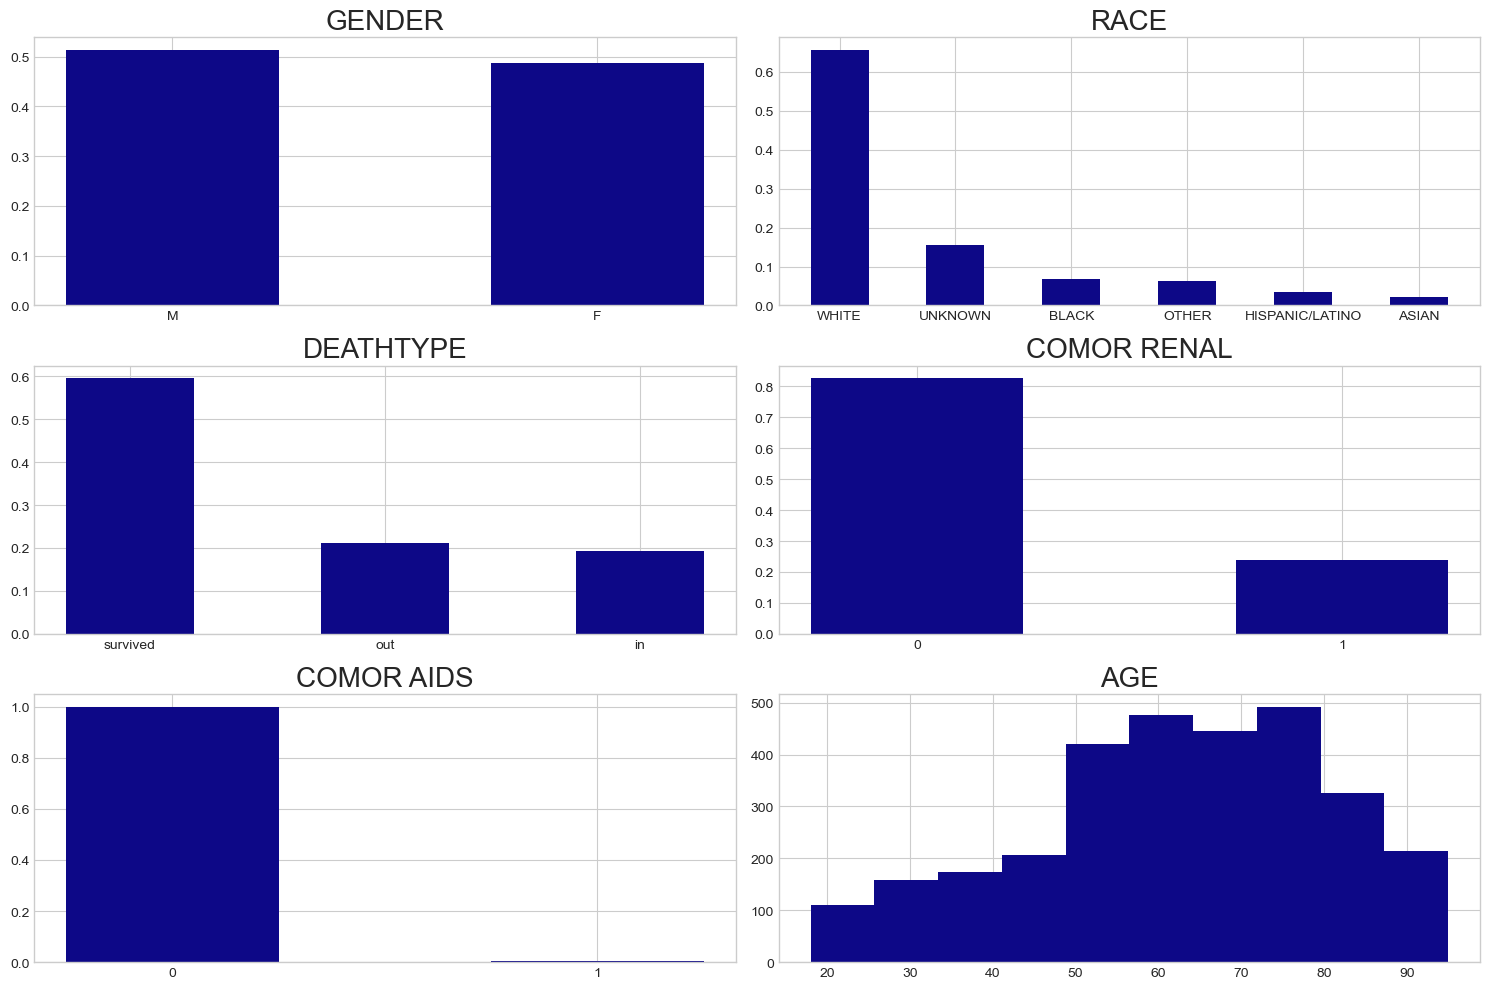

In [31]:
# static information visualization
fig = plt.figure(figsize=(15, 10))
for idx, item in enumerate(['gender', 'race', 'deathtype', 'comor_renal', 'comor_AIDS', 'age']):
    ax = fig.add_subplot(3, 2, idx+1)
    ax.set_title(item.replace('_', ' ').upper(), size=20)
    if item == 'age':
        tmp = static_info[['hadm_id', item]].drop_duplicates()[item]
        ax.hist(tmp, color=plt.cm.get_cmap(cmap_name)(0))
    else:
        tmp = static_info[['subject_id', item]].drop_duplicates()[item].value_counts()/len(static_info.subject_id.unique())
        ax.bar(tmp.index.astype(str), tmp, color=plt.cm.get_cmap(cmap_name)(0), width=0.5)

plt.tight_layout()

C:\Users\USER\AppData\Local\Temp\ipykernel_20868\2047638338.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.hist(tmp, color=plt.cm.get_cmap(cmap_name)(0))
C:\Users\USER\AppData\Local\Temp\ipykernel_20868\2047638338.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.bar(tmp.index.astype(int).astype(str), tmp, color=plt.cm.get_cmap(cmap_name)(0), width=0.5)
C:\Users\USER\AppData\Local\Temp\ipykernel_20868\2047638338.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


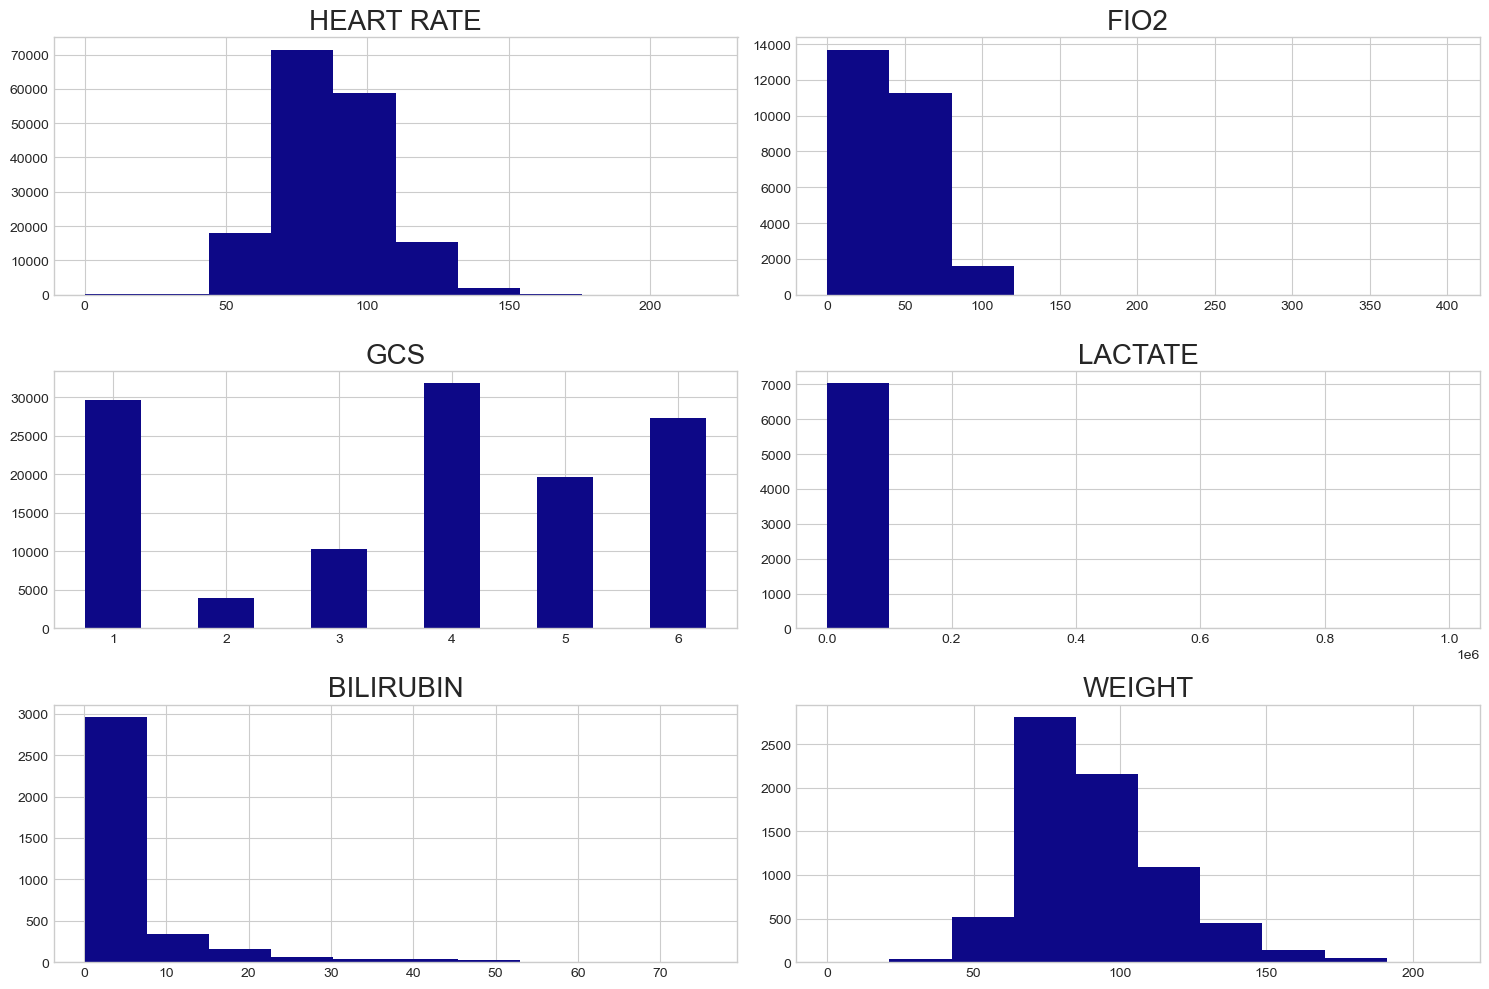

In [32]:
# demo, vital, lab value visualization
fig = plt.figure(figsize=(15, 10))
for idx, item in enumerate(['heart_rate', 'fio2', 'gcs', 'lactate', 'bilirubin', 'weight']):
    tmp = icu_DLV.loc[icu_DLV.itemid.isin(query_dict[item]), 'valuenum']
    ax = fig.add_subplot(3, 2, idx+1)
    ax.set_title(item.replace('_', ' ').upper(), size=20)
    if item == 'gcs':
        tmp = tmp.value_counts().sort_index()
        ax.bar(tmp.index.astype(int).astype(str), tmp, color=plt.cm.get_cmap(cmap_name)(0), width=0.5)
    else:
        ax.hist(tmp, color=plt.cm.get_cmap(cmap_name)(0))

plt.tight_layout()

### 1.3 frequency measure

In [33]:
# frequency measure
icu_DLV = icu_DLV.sort_values('charttime')
def frequency(x, itemids):
    x = x.loc[x.itemid.isin(itemids)]

    if x.shape[0] <= 1:
        return None
    else:
        tmp = x.charttime - x.charttime.shift(1)
        return tmp.dropna().mean()

freq_dict = {}
for idx, item in enumerate(['heart_rate', 'fio2', 'gcs', 'lactate', 'bilirubin', 'weight']):
    freq_dict[item] = icu_DLV.groupby('stay_id').apply(partial(frequency, itemids=query_dict[item])).dropna()/datetime.timedelta(hours=1)

In [34]:
for idx, item in enumerate(['heart_rate', 'fio2', 'gcs', 'lactate', 'bilirubin', 'weight']):
    print(f'{item} mean frequency: {freq_dict[item].mean()} hr')

heart_rate mean frequency: 0.9553895604877153 hr
fio2 mean frequency: 3.9286514331649527 hr
gcs mean frequency: 1.3077429700480736 hr
lactate mean frequency: 14.711257881824151 hr
bilirubin mean frequency: 27.371086924588784 hr
weight mean frequency: 30.40950529660665 hr


C:\Users\USER\AppData\Local\Temp\ipykernel_20868\2283160212.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.hist(tmp, bins=30, color=plt.cm.get_cmap(cmap_name)(0))


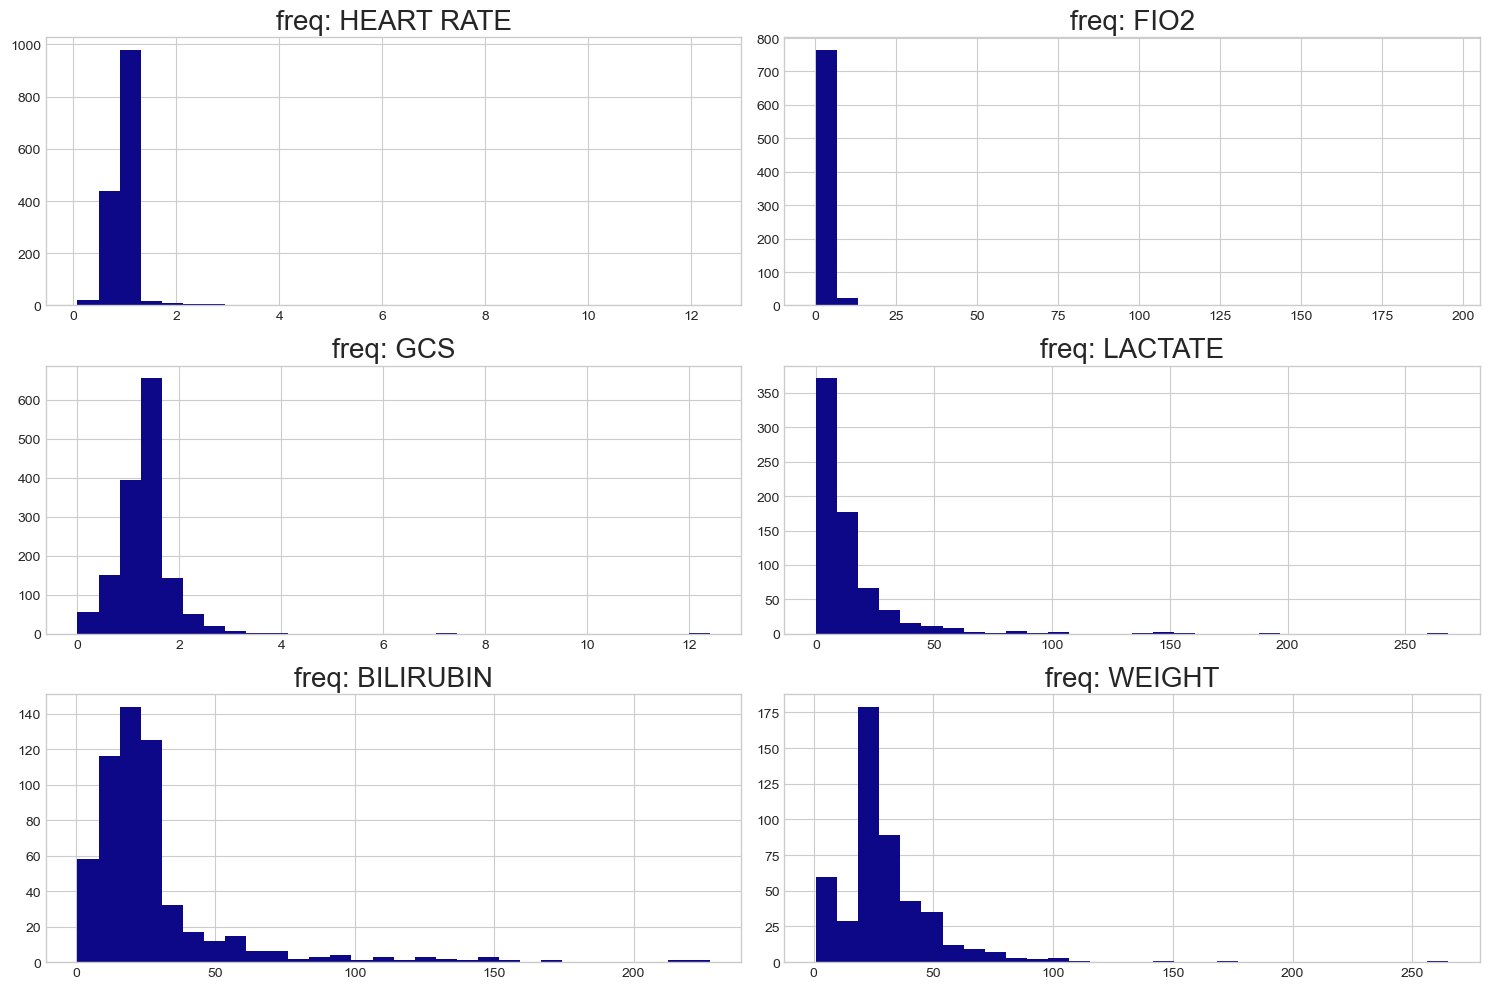

In [35]:
# frequency visualization
fig = plt.figure(figsize=(15, 10))
for idx, item in enumerate(['heart_rate', 'fio2', 'gcs', 'lactate', 'bilirubin', 'weight']):
    tmp = freq_dict[item]
    ax = fig.add_subplot(3, 2, idx+1)
    ax.set_title('freq: '+item.replace('_', ' ').upper(), size=20)

    ax.hist(tmp, bins=30, color=plt.cm.get_cmap(cmap_name)(0))

plt.tight_layout()

### 1.4 missing value check

#### static inforamtion

In [36]:
# static information
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in static_info.columns:
    if static_info[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')
'''
stay_id, intime, outtime에 존재하는 결측치는 중환자실 입원이 없었던 hadm_id에서는 일어날 수 있는 일임.
이를 확인해보자.
'''
tmp = static_info[['stay_id', 'intime', 'outtime']].copy()
for col in ['stay_id', 'intime', 'outtime']:
    tmp[col] = np.where(pd.isna(tmp[col]), 0, 1)

tmp.drop_duplicates().reset_index(drop=True)

# stay_id가 존재하는 경우(1) intime과 outtime 모두 존재하고 -> 통과
# 누락된 경우(0) intime과 outtime 모두 없음을 확인함 -> 통과

# if stay_id exists (1), intime and outtime both exists -> correct
# if stay_id does not exist (0), intime and outtime both do not exist -> correct

결측치가 존재하는 column: stay_id
결측치가 존재하는 column: intime
결측치가 존재하는 column: outtime
결측치가 존재하는 column: deathtime


,stay_id,intime,outtime
0,0,0,0
1,1,1,1


In [60]:
'''
deathtime의 경우 병원 내 혹은 외에서 퇴원 후 1년내에 사망했을 경우 기록되는 것이므로, 결측치가 존재할 수 있음
그러나 병원 내 혹은 외에서 사망한 경우에는, 즉 deathtype이 in 혹은 out인 경우에는 deathtime이 없다면 오류임
더불어 사망하지 않은 경우, 즉 deathtype이 survived인 경우 deathtime이 있다면 오류임
이를 확인해보자

missing data could exist (and it does) for deathtime
However, if patient is recorded as dead (in or out), deathtime must be recorded. Otherewise, this is an error
Also, if patient is recorded as survived, deathtime must not be recorded. Otherwise, this is also an error
Let's check if these errors exist
'''
tmp = static_info[['deathtype', 'deathtime']].copy()
tmp['deathtime'] = np.where(pd.isna(tmp['deathtime']), 0, 1)
tmp.drop_duplicates().reset_index(drop=True)
# survived인 경우에만 deathtime 기록이 누락된 것을 확인할 수 있음

,deathtype,deathtime
0,out,1
1,survived,0
2,in,1


#### icu_DLV

In [61]:
# icu_DLV
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in icu_DLV.columns:
    if icu_DLV[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')

결측치가 존재하는 column: value
결측치가 존재하는 column: valuenum
결측치가 존재하는 column: valueuom


In [62]:
for item in [i for i in items if i not in ['vasopressor', 'ventilator', 'blood_culture', 'antibiotic']]:
    itemids = query_dict[item]
    print(f'{item}에서 결측치가 존재하는 column:', end=' ')
    for col in ['value', 'valuenum', 'valueuom']:
        if icu_DLV.loc[icu_DLV.itemid.isin(itemids), col].isna().any():
            print(f'{col}', end=' ')
    print()

# fio2, gcs, bilirubin, creatinine, platelets의 valueuom에만 결측치가 존재함을 알 수 있음.
# 그러나 fio2는 일반적으로 사용하는 단위가 하나만 존재하고, gcs는 단위가 없으므로(점수임) 결측치가 존재할 수 있음

# Missing data only exists in valueuom column for fio2, gcs, bilirubin, creatinine, platelets
# But fi02 should have only one unit, and gcs does not have unit, so we should check these two items

creatinine에서 결측치가 존재하는 column: valueuom 
pao2에서 결측치가 존재하는 column: 
platelets에서 결측치가 존재하는 column: valueuom 
dbp에서 결측치가 존재하는 column: 
resp_rate에서 결측치가 존재하는 column: 
gcs에서 결측치가 존재하는 column: valueuom 
bilirubin에서 결측치가 존재하는 column: valueuom 
weight에서 결측치가 존재하는 column: 
temperature에서 결측치가 존재하는 column: 
sbp에서 결측치가 존재하는 column: 
heart_rate에서 결측치가 존재하는 column: 
height에서 결측치가 존재하는 column: 
lactate에서 결측치가 존재하는 column: 
fio2에서 결측치가 존재하는 column: valueuom 


In [63]:
# fio2와 gcs의 valueuom은 전부 결측치인지 확인해보자
# let's check if all valueuom values are missing for fio2 and gcs
for item in ['fio2', 'gcs']:
    itemids = query_dict[item]
    print(f'{item}의 valueuom은 전부 결측치인가?: {icu_DLV.loc[icu_DLV.itemid.isin(itemids), "valueuom"].isna().all()}')
# 전부 결측치이므로 기본 단위라고 가정할 수 있음
# we can assume standard units since all values are missing

fio2의 valueuom은 전부 결측치인가?: True
gcs의 valueuom은 전부 결측치인가?: True


In [64]:
# 나머지 변수들의 valueuom의 종류를 확인해보자
# let's check the remaining items' valueuom types
for item in [i for i in items if i not in ['vasopressor', 'ventilator', 'blood_culture', 'antibiotic', 'fio2', 'gcs']]:
    itemids = query_dict[item]
    print(f'{item} 단위 종류: {icu_DLV.loc[icu_DLV.itemid.isin(itemids), "valueuom"].unique()}')

# 단위가 기록되지 않은 경우 단순 누락으로 가정할 수 있음
# 단위가 두 종류 기록된 height와 temperature는 단위 통일이 필요함을 알 수 있음

# for items that have only one unit, we can assume nan is simply an omission
# but for height and temperature which have two types of units, we need to convert the units at a later point

creatinine 단위 종류: ['mg/dL' nan]
pao2 단위 종류: ['mmHg']
platelets 단위 종류: ['K/uL' nan]
dbp 단위 종류: ['mmHg']
resp_rate 단위 종류: ['insp/min']
bilirubin 단위 종류: ['mg/dL' nan]
weight 단위 종류: ['kg']
temperature 단위 종류: ['°F' '°C']
sbp 단위 종류: ['mmHg']
heart_rate 단위 종류: ['bpm']
height 단위 종류: ['cm' 'Inch']
lactate 단위 종류: ['mmol/L']


#### icu_med

In [70]:
# icu_med
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in icu_med.columns:
    if icu_med[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')

결측치가 존재하는 column: rate
결측치가 존재하는 column: rateuom


In [71]:
itemids = query_dict['vasopressor']
print(f'vasopressor에서 결측치가 존재하는 column:', end=' ')
for col in ['rate', 'rateuom']:
    if icu_med.loc[icu_med.itemid.isin(itemids), col].isna().any():
        print(f'{col}', end=' ')
print()
# vasopressor 정보의 경우 어떤 결측치도 없음
# no missing data in vasopressor

vasopressor에서 결측치가 존재하는 column: 


In [72]:
itemids = query_dict['antibiotic_id']
print(f'antibiotic 정보 중 결측치가 존재하는 column:', end=' ')
for col in ['rate', 'rateuom']:
    if icu_med.loc[icu_med.itemid.isin(itemids), col].isna().any():
        print(f'{col}', end=' ')
print()
# antibiotic 정보에는 결측치가 존재함
# missing data exists in antibiotic

antibiotic 정보 중 결측치가 존재하는 column: rate rateuom 


In [73]:
icu_med.loc[icu_med.itemid.isin(itemids), ['rate', 'rateuom']].isna().all()
# 모든 rate, rateuom 정보가 없음을 알 수 있음.
# 이는 antibiotic의 경우 지속적으로 투여하는 약물이 아니라 한번에 투여하는 방식의 약물이기 때문임
# 실제로 starttime과 endtime을 보면 starttime+1분 = endtime임을 알 수 있음

# we can see that all rate and rateuom is missing
# this could be because antibiotics are generally given in one-shot (syringe, bolus, oral) rather than continuosly
# for these types of items, mimic records the endtime as starttime+1minute
# we can check whether this rule holds true for all entries in antibiotic

rate       True
rateuom    True
dtype: bool

In [74]:
tmp = icu_med.loc[icu_med.itemid.isin(itemids), ['starttime', 'endtime']].copy()
(tmp['starttime']+datetime.timedelta(minutes=1)==tmp['endtime']).all()

True

#### icu_proc

In [47]:
# icu_proc
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in icu_proc.columns:
    if icu_proc[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')
# 결측치가 존재하는 column이 없음
# no missing data

#### hosp_diag

In [48]:
# hosp_diag
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in hosp_diag.columns:
    if hosp_diag[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')
# 결측치가 존재하는 column이 없음

#### hosp_test

In [49]:
# hosp_test
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in hosp_test.columns:
    if hosp_test[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')

결측치가 존재하는 column: hadm_id
결측치가 존재하는 column: charttime


In [50]:
itemids = query_dict['blood_culture']
print(f'blood_culture 정보 중 결측치가 존재하는 column:', end=' ')
for col in hosp_test.columns:
    if hosp_test.loc[hosp_test.itemid.isin(itemids), col].isna().any():
        print(f'{col}', end=' ')
print()

blood_culture 정보 중 결측치가 존재하는 column: hadm_id charttime 


In [51]:
tmp = hosp_test.loc[hosp_test.itemid.isin(itemids), ['hadm_id', 'charttime']].copy()
for col in ['hadm_id', 'charttime']:
    tmp[col] = np.where(pd.isna(tmp[col]), 0, 1)

tmp.drop_duplicates().reset_index(drop=True)

# charttime은 있고, hadm_id는 없는 case를 처리해야 함
# 이러한 case의 subject에 해당하는 charttime subject_id의 여러 hadm_id 중 하나의 admittime, dischtime 사이에 있는 경우 이 hadm_id를 부여하고
# 만약 어떤 admittime, dischtime사이에 존재하는 정보가 아닌 경우, 이를 제거하자

# we have to handle the cases where charttime exists but hadm_id does not
# for these cases, we can identify one of the charttime subject_id and check its hadm_id
# if this hadm_id's admittime and dischtime contains charttime, we use this hadm_id to fill in the missing value
# if none of such hadm_id's exist, we can just remove the case

,hadm_id,charttime
0,1,1
1,0,1
2,0,0


In [52]:
tmp_df = hosp_test.loc[pd.notna(hosp_test['charttime'])&pd.isna(hosp_test['hadm_id']), ['subject_id', 'hadm_id', 'charttime']]
tmp_df

,subject_id,hadm_id,charttime
0,sub-126,NaN,2109-12-13 00:33:00
1,sub-126,NaN,2109-12-13 00:33:00
13,sub-126,NaN,2110-03-26 03:23:00
14,sub-126,NaN,2110-03-26 03:23:00
15,sub-126,NaN,2110-03-26 03:23:00
...,...,...,...
41860,sub-422,NaN,2112-03-06 10:10:00
41861,sub-422,NaN,2112-03-06 10:10:00
41862,sub-422,NaN,2112-03-06 10:10:00
41863,sub-422,NaN,2112-03-06 10:10:00


In [53]:
def msv_handler_hosp_test(x):
    # 문제가 되는 경우만 필터링했다고 가정함
    sbj_id = x['subject_id'].values[0]
    for adm_id, at, dt in static_info.query(f'subject_id=="{sbj_id}"')[['hadm_id', 'admittime', 'dischtime']].values:
        condition = (at <= tmp_df['charttime']) & (tmp_df['charttime'] <= dt)
        x.loc[condition, 'hadm_id'] = adm_id

    return x

tmp_df = tmp_df.groupby('subject_id', group_keys=False).apply(msv_handler_hosp_test)
tmp_df.dropna()

,subject_id,hadm_id,charttime
518,sub-814,adm-1849,2113-07-21 13:05:00
695,sub-403,adm-700,2111-05-09 17:40:00
1772,sub-641,adm-1420,2112-10-06 02:30:00
2103,sub-213,adm-268,2110-07-17 17:53:00
2166,sub-710,adm-1574,2112-11-26 03:25:00
...,...,...,...
40841,sub-390,adm-640,2111-01-09 11:45:00
40842,sub-390,adm-640,2111-01-09 12:00:00
41033,sub-232,adm-2806,2116-03-06 14:39:00
41427,sub-919,adm-2521,2114-09-02 20:40:00


In [54]:
# 기존 hosp_test에 처리된 hadm_id를 추가하고, 결측치를 제거하자.
# input the hadm_ids's that we just processed
hosp_test.loc[tmp_df.index, 'hadm_id'] = tmp_df['hadm_id'].copy()
hosp_test = hosp_test.dropna().reset_index(drop=True)

#### hosp_med

In [55]:
# hosp_med
# 전체 데이터셋에서 결측치가 존재하는 column을 검사해보자
# let's identify the columns where missing data exist

for col in hosp_med.columns:
    if hosp_med[col].isna().sum() > 0:
        print(f'결측치가 존재하는 column: {col}')

결측치가 존재하는 column: starttime
결측치가 존재하는 column: endtime


In [56]:
# antibiotic 정보중 starttime이나 stoptime이 누락된 경우를 살펴보자
# let's check antibiotic information where starttime or endtime is missing

query = '|'.join(query_dict['antibiotic_name'])
condition = hosp_med.drug.astype(str).str.lower().str.contains(query)
missing_idx = hosp_med.loc[condition, ['starttime', 'endtime']].isna().all(axis=1).map({True: True, False:None}).dropna().index
hosp_med.loc[missing_idx]
# 해당 정보들의 경우 hadm_id를 이용한 분석만 가능함을 알 수 있다.
# we can only analyze the following dataset using hadm_id since we cannot identify their given time

,hadm_id,subject_id,starttime,endtime,drug
15944,adm-1010,sub-488,NaT,NaT,Linezolid
16006,adm-1010,sub-488,NaT,NaT,Linezolid
53060,adm-1846,sub-613,NaT,NaT,Sulfameth/Trimethoprim DS
53111,adm-1846,sub-613,NaT,NaT,Sulfameth/Trimethoprim DS
62714,adm-2812,sub-684,NaT,NaT,Sulfameth/Trimethoprim SS
62727,adm-2812,sub-684,NaT,NaT,Sulfameth/Trimethoprim SS
62845,adm-2812,sub-684,NaT,NaT,Sulfameth/Trimethoprim SS
73433,adm-2633,sub-586,NaT,NaT,Sulfameth/Trimethoprim SS
73492,adm-2633,sub-586,NaT,NaT,Sulfameth/Trimethoprim SS
73696,adm-2633,sub-586,NaT,NaT,Sulfameth/Trimethoprim SS


In [57]:
# 쉬운 분석을 위해 해당 정보를 삭제함
# let's just remove such cases for the ease of analysis

hosp_med.drop(missing_idx, inplace=True)

In [58]:
# 둘 중 하나만 결측치인 경우 다른 하나+= 1분으로 로 채워넣자
# if only either case is missing, replace the other one with +-1 minute
hosp_med.loc[condition&hosp_med['starttime'].isna(), 'starttime'] = hosp_med.loc[condition&hosp_med['starttime'].isna(), 'endtime'].copy()-datetime.timedelta(minutes=1)
hosp_med.loc[condition&hosp_med['endtime'].isna(), 'endtime'] = hosp_med.loc[condition&hosp_med['endtime'].isna(), 'starttime'].copy()+datetime.timedelta(minutes=1)

In [59]:
# 다시 검사해보자
# recheck missing data
query = '|'.join(query_dict['antibiotic_name'])
condition = hosp_med.drug.astype(str).str.lower().str.contains(query)
missing_idx = hosp_med.loc[condition, ['starttime', 'endtime']].isna().any(axis=1).map({True: True, False:None}).dropna().index
hosp_med.loc[missing_idx]

,hadm_id,subject_id,starttime,endtime,drug


### 1.5 outlier visualization using boxplot

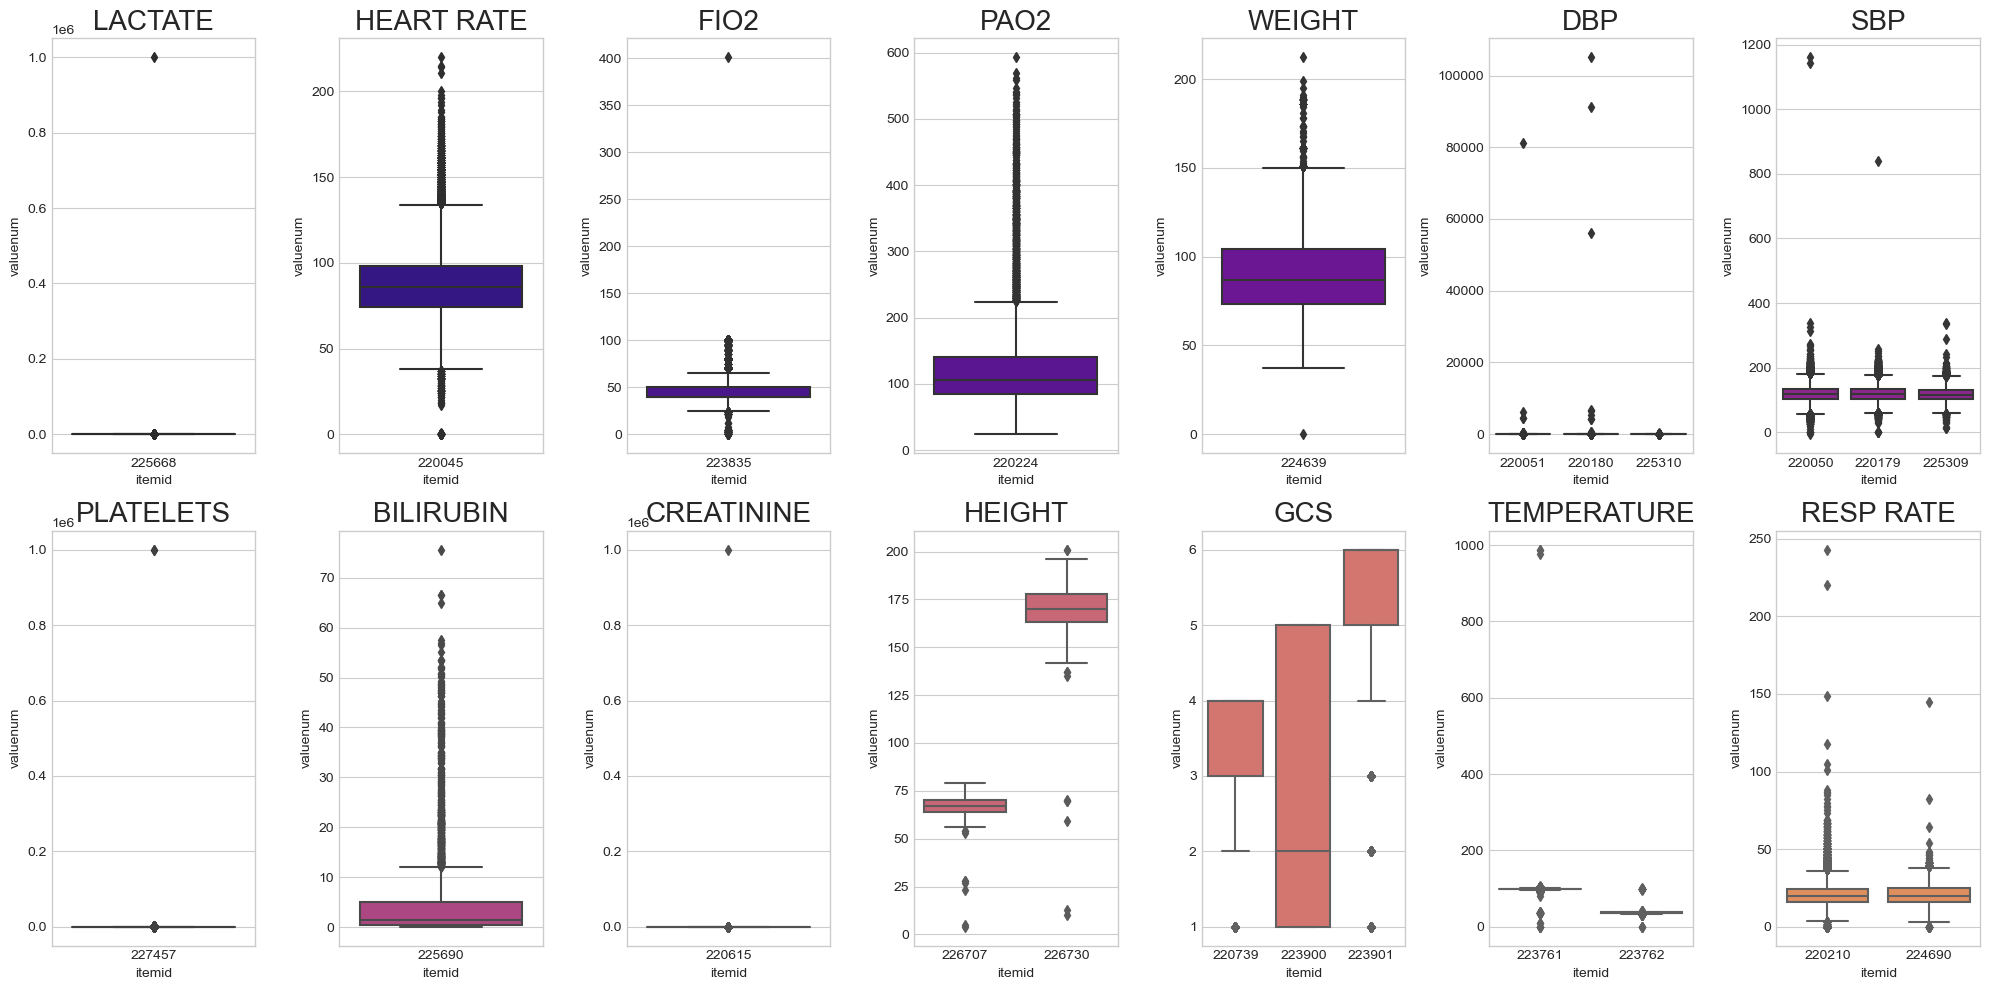

In [51]:
fig = plt.figure(figsize=(20, 10))
for idx, item in enumerate([i for i in items if i not in ['vasopressor', 'ventilator', 'blood_culture', 'antibiotic']]):
    ax = fig.add_subplot(2, 7, idx+1)
    ax.set_title(item.replace('_', ' ').upper(), size=20)
    sns.boxplot(y='valuenum', x='itemid', data=icu_DLV.loc[icu_DLV.itemid.isin(query_dict[item])], color=plt.cm.get_cmap(cmap_name)(idx/len(items)))

plt.tight_layout()

## 2. Data Preprocessing

### 2.1 data refining

#### 2.1.1 unit conversion

In [52]:
# icu_DLV
# height와 temperature에서만 진행하면됨
# unit conversion needs be done only for height and temperature

# height
condition = icu_DLV.itemid.isin(query_dict['height'])&(icu_DLV['valueuom']=='Inch')
icu_DLV.loc[condition, 'valuenum'] = icu_DLV.loc[condition, 'valuenum'].copy()*2.54
icu_DLV.loc[condition, 'valueuom'] = 'cm'

In [53]:
# temperature
condition = icu_DLV.itemid.isin(query_dict['temperature'])&(icu_DLV['valueuom']=='°F')
icu_DLV.loc[condition, 'valuenum'] = (icu_DLV.loc[condition, 'valuenum'].copy()-32)*5/9
icu_DLV.loc[condition, 'valueuom'] = '°C'

In [54]:
# icu_med
# 각 itemid별로 서로 다른 amount 단위와 rate 단위를 가지는 지 확인
# 그런 경우는 없음

# check whether multiple amountuom or rateuom exists for an itemid
# we can see there exists no such cases

condition = icu_med.itemid.isin(query_dict['vasopressor'])
icu_med.loc[condition, ['itemid', 'amountuom', 'rateuom']].value_counts()

itemid  amountuom  rateuom   
221906  mg         mcg/kg/min    11623
221749  mg         mcg/kg/min     4557
229630  mg         mcg/kg/min      983
222315  units      units/hour      846
221289  mg         mcg/kg/min      659
229632  mg         mcg/kg/min      514
221662  mg         mcg/kg/min      481
221653  mg         mcg/kg/min      272
dtype: int64

#### 2.1.2 outlier handling

In [55]:
# 데이터 셋의 itemid를 비롯한 식별자를 itemid_mapping을 이용해 변환하고, query dict에 없는 item의 데이터는 제거하자.
# change the itemid to its name using itemid_mapping previously defined

for tmp_df in [icu_DLV, icu_med, icu_proc, hosp_med, hosp_test]:
    try:
        tmp_df['itemid'] = tmp_df['itemid'].map(itemid_mapping)
        tmp_df.dropna(subset='itemid', inplace=True)

    except KeyError:
        query = '|'.join(query_dict['antibiotic_name'])
        condition = tmp_df.drug.astype(str).str.lower().str.contains(query)
        tmp_df.loc[condition, 'drug'] = 'antibiotic'
        tmp_df.columns = [i if i != 'drug' else 'itemid' for i in tmp_df.columns]
        tmp_df.dropna(subset='itemid', inplace=True)

In [56]:
'''
이상치를 제거하는 방법으로는 크게 4가지가 있음
1. standard deviation을 기준으로 제거하기: 평균을 기준으로 표준편차를 넘어가면 제거하는 방식을 사용할 수 있다.
2. IQR을 기준으로 제거하기: 일반적으로 Q1-1.5IQR 보다 작은 값, Q3+1.5IQR보다 큰 값을 제거하곤 한다.
3. 머신러닝 모델을 이용하기: 이상치 탐지 알고리즘을 이용해 이상치를 제거할 수 있다.
4. 도메인 지식을 이용하기: 의료분야의 경우 이 방법을 사용하는 것이 가장 일반적일 수 있는데, 각 변수의 값이 실제 생리학적 이론 및 임상 지식에 따라 가능한 범위가 결정되어 있을 수 있기 때문이다.
    eg. GCS의 경우 의료진이 환자 상태를 평가한 평가 점수이고 eye/verbal/motor 기능 측정 후 각각을 1~4점, 1~5점, 1~6점 사이로 평가하기 때문에 상기 1~3번 방법은 GCS에는 적용해서는 안되는 방법이다.

여기서는 1,2,4를 실습해보자

let's remove outliers. there exists 4 ways we can do this
1. use standard deviation: remove the values that exceed the mean value by one standard deviation
2. use IQR (Q3-Q1): remove the values smaller than Q1-1.5IQR or larger than Q3+1.5IQR
3. use machine learning models: use outlier detection algorithms
4. use domain knowledge: for medical applications, this could be the most common way to handle outliers. each feature could have possible ranges defined by medical knwoledge.

let's try 1,2,4 methods
'''
def outlier_handler(df, how, items, **kwargs):
    # df: should be icu_DLV or icu_med
    if how == 'std':
        outlier_idx = []
        for itemid in items:
            if df.query(f'itemid=="{itemid}"').shape[0] > 0:
                if 'charttime' in df.columns:
                    item_val = df.query(f'itemid=="{itemid}"')['valuenum']
                    mu = item_val.mean()
                    std = item_val.std()
                    stdzd_value = (item_val-mu)/std

                    outlier_idx += stdzd_value[np.abs(stdzd_value)>=kwargs['std']].index.tolist()
                else:
                    for col in ['amount', 'rate']:
                        item_val = df.query(f'itemid=="{itemid}"')[col]
                        mu = item_val.mean()
                        std = item_val.std()
                        stdzd_value = (item_val-mu)/std

                        outlier_idx += stdzd_value[np.abs(stdzd_value)>=kwargs['std']].index.tolist()

        return df.drop(outlier_idx).reset_index(drop=True)

    elif how == 'iqr':
        outlier_idx = []
        for itemid in items:
            if df.query(f'itemid=="{itemid}"').shape[0] > 0:
                if 'charttime' in df.columns:
                    item_val = df.query(f'itemid=="{itemid}"')['valuenum']
                    q1 = item_val.quantile(0.25)
                    q3 = item_val.quantile(0.75)
                    iqr = q3-q1

                    condition = (item_val > 1.5*iqr+q3) | (item_val < q1-1.5*iqr)
                    outlier_idx += item_val[condition].index.tolist()

                else:
                    for col in ['amount', 'rate']:
                        item_val = df.query(f'itemid=="{itemid}"')[col]
                        q1 = item_val.quantile(0.25)
                        q3 = item_val.quantile(0.75)
                        iqr = q3-q1

                        condition = (item_val > 1.5*iqr+q3) | (item_val < q1-1.5*iqr)
                        outlier_idx += item_val[condition].index.tolist()

        return df.drop(outlier_idx).reset_index(drop=True)

    elif how == 'domain':
        outlier_criteria = pd.read_excel('outlier_criteria.xlsx', 'simple')
        outlier_idx = []
        for itemid in items:
            if df.query(f'itemid=="{itemid}"').shape[0] > 0:
                try:
                    lb, ub, lb_incl, ub_incl = outlier_criteria.query(f'variables=="{itemid}"')[['lb', 'ub', 'lb_inclusion', 'ub_inclusion']].values.ravel()
                    if 'charttime' in df.columns :
                        item_val = df.query(f'itemid=="{itemid}"')['valuenum']

                        condition = (item_val > ub) | (item_val < lb) | ub_incl*(item_val == ub) | lb_incl*(item_val == lb)
                        outlier_idx += item_val[condition].index.tolist()

                    else:
                        for col in ['amount', 'rate']:
                            item_val = df.query(f'itemid=="{itemid}"')[col]

                            condition = (item_val > ub) | (item_val < lb) | ub_incl*(item_val == ub) | lb_incl*(item_val == lb)
                            outlier_idx += item_val[condition].index.tolist()
                except:
                    pass

        return df.drop(outlier_idx).reset_index(drop=True)

    else:
        raise LookupError

In [57]:
for how in ['std', 'iqr', 'domain']:
    print(f'outlier handling method: {how}')
    if how == 'std':
        for std in [1,2,3]:
            print(f'std={std}인 경우 제거된 row의 수: {icu_DLV.shape[0]-outlier_handler(icu_DLV, how, items, std=std).shape[0]}')
    else:
        print(f'제거된 row의 수: {icu_DLV.shape[0]-outlier_handler(icu_DLV, how, items, std=std).shape[0]}')

outlier handling method: std
std=1인 경우 제거된 row의 수: 165382
std=2인 경우 제거된 row의 수: 23524
std=3인 경우 제거된 row의 수: 5965
outlier handling method: iqr
제거된 row의 수: 18305
outlier handling method: domain
제거된 row의 수: 1174


In [58]:
for how in ['std', 'iqr', 'domain']:
    print(f'outlier handling method: {how}')
    if how == 'std':
        for std in [1,2,3]:
            print(f'std={std}인 경우 제거된 row의 수: {icu_med.shape[0]-outlier_handler(icu_med, how, items, std=std).shape[0]}')
    else:
        print(f'제거된 row의 수: {icu_med.shape[0]-outlier_handler(icu_med, how, items, std=std).shape[0]}')

outlier handling method: std
std=1인 경우 제거된 row의 수: 1333
std=2인 경우 제거된 row의 수: 666
std=3인 경우 제거된 row의 수: 550
outlier handling method: iqr
제거된 row의 수: 3920
outlier handling method: domain
제거된 row의 수: 0


In [59]:
icu_DLV = outlier_handler(icu_DLV, 'domain', items)

#### 2.1.3 time error handling

In [60]:
# admsission의 admittime과 dischtime 밖에 기록된 데이터 row를 제거하자.
# delete rows whose records were recorded outside of admittime and dischtime
def time_error_handler(x):
    adm_ids = x['hadm_id'].unique()
    try:
        time_error_idx = []
        for adm_id in adm_ids:
            at, dt = static_info.query(f'hadm_id=="{adm_id}"')[['admittime', 'dischtime']].drop_duplicates().values.ravel()
            if 'charttime' in x.columns:
                tmp_df = x.loc[x['hadm_id']==adm_id, ['charttime']]
                condition = (at > tmp_df['charttime']) | (tmp_df['charttime'] > dt)
                time_error_idx += condition[condition].index.tolist()

            elif 'endtime' in x.columns:
                tmp_df = x.loc[x['hadm_id']==adm_id, ['starttime', 'endtime']]
                condition = (at > tmp_df['endtime']) | (tmp_df['starttime'] > dt)
                time_error_idx += condition[condition].index.tolist()

        return x.drop(time_error_idx).reset_index(drop=True)

    except:
        print(adm_id)

In [61]:
for tmp_df in [icu_DLV, icu_med, icu_proc, hosp_med, hosp_test]:
    print(f'원래 row의 수: {tmp_df.shape[0]}, 제거 후: {tmp_df.groupby("subject_id", group_keys=False).apply(time_error_handler).reset_index(drop=True).shape[0]}')

원래 row의 수: 933113, 제거 후: 932805
원래 row의 수: 36912, 제거 후: 36912
원래 row의 수: 1652, 제거 후: 1652
원래 row의 수: 220686, 제거 후: 219438
원래 row의 수: 8633, 제거 후: 8633


In [62]:
icu_DLV = icu_DLV.groupby("subject_id").apply(time_error_handler).reset_index(drop=True)
hosp_med = hosp_med.groupby("subject_id").apply(time_error_handler).reset_index(drop=True)

### 2.2 variable wise handling

#### 2.2.1 GCS

In [63]:
'''
의료데이터 중 어떤 항목의 경우 그 변수의 측정방식 등의 특성을 고려하여 전처리해야 하는 경우가 있다.
예를 들면 GCS가 그러한데, GCS는 eye, verval, motor로 나눠서 측정되는 값으로, GCS를 계산하기 위해서는 같은 시각에 측정된 eye, verbal, motor 값을 더해야 한다.
GCS 처리를 진행해보자.

there could be some medical features that need to be preprocessed in an unique way
GCS is an example where GCS consists of eye, verbal, motor related scores
in order to compute GCS, we need to add the eye, verbal, motor scores measured at the same timepoint
'''
def gcs_handler(x):
    cts = x.loc[x.itemid.str.contains('gcs'), 'charttime'].unique()
    sty, adm, sbj = x[['stay_id', 'hadm_id', 'subject_id']].values[0]
    drop_idx = []
    for ct in cts:
        condition = (x['charttime']==ct) & (x.itemid.str.contains('gcs'))
        tmp_df = x.loc[condition, ['itemid']].drop_duplicates()
        if len(tmp_df) == 3:
            x.loc[x.index[-1]+1] = [sty, adm, sbj, ct, 'gcs', None, x.loc[condition, 'valuenum'].sum(), None]

        elif len(tmp_df) < 3:
            missing_gcs = [i for i in ['gcs_eye', 'gcs_verbal', 'gcs_motor'] if i not in tmp_df['itemid']]
            tmp_gcs = 0
            for gcs in missing_gcs:
                if gcs == 'gcs_eye':
                    tmp_gcs += 3
                elif gcs == 'gcs_verbal':
                    tmp_gcs += 3
                else:
                    tmp_gcs += 4
            tmp_gcs += x.loc[condition, 'valuenum'].sum()
            x.loc[x.index[-1]+1] = [sty, adm, sbj, ct, 'gcs', None, tmp_gcs, None]
        else:
            drop_idx += condition.index[condition].tolist()

    return x.drop(drop_idx).reset_index(drop=True)

tmp_df = icu_DLV.groupby('stay_id').apply(gcs_handler).reset_index(drop=True)

In [64]:
icu_DLV = tmp_df.copy()

### 2.3 sequential merging and resampling

#### sequential merging -> resampling -> missing value handling

## 3. Modeling and Evaluation

### 3.1 data preparation

In [65]:
preprocessed_df = pd.read_csv('preprocessed_df.csv')

In [66]:
'''
본격적으로 머신러닝 모델을 활용해 예측 모델을 구축하기 앞서 추가 준비과정이 필요하다.
state annoation, split, normalization/standardization, prediction target labeling을 비롯한 과정을 수행해보자

We need some additional steps prior to building a ML predictive model
Let's perform state annoation, split, normalization/standardization, prediction target labeling steps
'''
# race와 gender를 one hot encoding
# one hot encoding of race and gender
preprocessed_df = pd.concat([preprocessed_df, pd.get_dummies(preprocessed_df['race'])], axis=1)
preprocessed_df['gender'] = np.where(preprocessed_df['gender'] == 'F', 1, 0)

In [67]:
# 분석에 필요없는 column을 제외해보자.
# gender, timestamps, hadm_id 제거
# stay_id는 stay별 분석이 필요할 수도 있으므로 제외

# remove the columns that are not necessary for analysis
# remove gender, timestamps, hadm_id columns
preprocessed_df = preprocessed_df.drop(columns=['race', 'timestamps', 'hadm_id'])

In [68]:
# 추가 변수를 만들어보자
# make aditional features
# BMI, MAP
preprocessed_df['BMI'] = np.nan_to_num(preprocessed_df['weight_mean'] / (preprocessed_df['height_mean']/100)**2, nan=0, posinf=0)
preprocessed_df['MAP'] = np.nan_to_num((preprocessed_df['sbp_mean']+2*preprocessed_df['dbp_mean'])/3, nan=0, posinf=0)

#### 3.1.1 state annotation & prediction labeling

In [69]:
# 예측하고자 하는 변수를 나타내고, 이를 기반으로 prediction target을 라벨링해보자
# 이번 실습의 예측 목표는 SOFA(sequential orgain failure assessment) 점수다.

# represent the target feature and set this as our prediction target
# for this demonstrative example, our prediction target is SOFA(sequential orgain failure assessment) score

def SOFA(df):
    # respiratory
    tmp_sofa = np.nan_to_num(df['pao2_mean'] / df['fio2_mean'], nan=0, posinf=0)
    tmp_sofa = 1*(tmp_sofa<400)+1*(tmp_sofa<300)+1*((tmp_sofa<200)*(preprocessed_df['ventilator']))+1*((tmp_sofa<100)*(preprocessed_df['ventilator']))
    df['resp_sofa'] = tmp_sofa

    # cardiovascular
    tmp_sofa = df['MAP']
    tmp_sofa = 1*(tmp_sofa<70)+2*(df['vasopressor'])
    df['cardio_sofa'] = tmp_sofa

    # coagulation
    tmp_sofa = df['platelets_mean']
    tmp_sofa = 1*(tmp_sofa<150)+1*(tmp_sofa<100)+1*(tmp_sofa<50)+1*(tmp_sofa<20)
    df['coag_sofa'] = tmp_sofa

    # liver
    tmp_sofa = df['bilirubin_mean']
    tmp_sofa = 1*(tmp_sofa>=1.2)+1*(tmp_sofa>=2)+1*(tmp_sofa>=6)+1*(tmp_sofa>=12)
    df['liver_sofa'] = tmp_sofa

    # central nervous system
    tmp_sofa = df['gcs_mean']
    tmp_sofa = 1*(tmp_sofa<15)+1*(tmp_sofa<13)+1*(tmp_sofa<10)+1*(tmp_sofa<6)
    df['cns_sofa'] = tmp_sofa

    # renal
    tmp_sofa = df['creatinine_mean']
    tmp_sofa = 1*(tmp_sofa>=1.2)+1*(tmp_sofa>=2)+1*(tmp_sofa>=3.5)+1*(tmp_sofa>=5)
    df['renal_sofa'] = tmp_sofa

    df['sofa'] = df['resp_sofa']+df['cardio_sofa']+df['coag_sofa']+df['liver_sofa']+df['cns_sofa']+df['renal_sofa']

    return df

preprocessed_df = SOFA(preprocessed_df)
preprocessed_df

,lactate_mean,lactate_max,lactate_min,lactate_median,lactate_first,lactate_last,resp_rate_mean,resp_rate_max,resp_rate_min,resp_rate_median,resp_rate_first,resp_rate_last,creatinine_mean,creatinine_max,creatinine_min,creatinine_median,creatinine_first,creatinine_last,platelets_mean,platelets_max,platelets_min,platelets_median,platelets_first,platelets_last,sbp_mean,sbp_max,sbp_min,sbp_median,sbp_first,sbp_last,height_mean,height_max,height_min,height_median,height_first,height_last,blood_culture,vasopressor,bilirubin_mean,bilirubin_max,bilirubin_min,bilirubin_median,bilirubin_first,bilirubin_last,antibiotic,pao2_mean,pao2_max,pao2_min,pao2_median,pao2_first,pao2_last,fio2_mean,fio2_max,fio2_min,fio2_median,fio2_first,fio2_last,ventilator,weight_mean,weight_max,weight_min,weight_median,weight_first,weight_last,heart_rate_mean,heart_rate_max,heart_rate_min,heart_rate_median,heart_rate_first,heart_rate_last,gcs_mean,gcs_max,gcs_min,gcs_median,gcs_first,gcs_last,temperature_mean,temperature_max,temperature_min,temperature_median,temperature_first,temperature_last,dbp_mean,dbp_max,dbp_min,dbp_median,dbp_first,dbp_last,stay_id,gender,age,comor_renal,comor_AIDS,comor_cancer,comor_liver,ASIAN,BLACK,HISPANIC/LATINO,OTHER,UNKNOWN,WHITE,BMI,MAP,resp_sofa,cardio_sofa,coag_sofa,liver_sofa,cns_sofa,renal_sofa,sofa
0,3.0,3.0,3.0,3.0,3.0,3.0,13.500000,17.0,6.0,14.0,17.0,13.0,0.5,0.5,0.5,0.5,0.5,0.5,190.0,211.0,169.0,190.0,169.0,211.0,103.466667,135.0,58.0,107.0,121.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.666667,309.0,133.0,247.0,309.0,133.0,60.0,100.0,40.0,50.0,100.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,76.222222,83.0,64.0,80.0,80.0,83.0,3.000000,3.0,3.0,3.0,3.0,3.0,36.611111,36.666667,36.555556,36.611111,36.555556,36.666667,61.733333,95.0,40.0,63.0,67.0,54.0,stay-1,1,61.0,0,0,0,0,0,0,0,0,0,1,0.0,75.644444,4.0,2.0,0,0,4,0,10.0
1,3.0,3.0,3.0,3.0,3.0,3.0,17.833333,21.0,15.0,17.5,21.0,20.0,0.5,0.5,0.5,0.5,0.5,0.5,190.0,211.0,169.0,190.0,169.0,211.0,105.428571,115.0,96.0,106.0,99.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.000000,129.0,129.0,129.0,129.0,129.0,60.0,100.0,40.0,50.0,100.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,89.333333,94.0,83.0,89.0,83.0,92.0,13.000000,15.0,10.0,14.0,10.0,15.0,36.972222,37.000000,36.944444,36.972222,36.944444,37.000000,69.857143,96.0,56.0,65.0,80.0,56.0,stay-1,1,61.0,0,0,0,0,0,0,0,0,0,1,0.0,81.714286,4.0,2.0,0,0,1,0,7.0
2,3.0,3.0,3.0,3.0,3.0,3.0,19.000000,25.0,15.0,18.0,25.0,15.0,0.4,0.4,0.4,0.4,0.4,0.4,148.0,148.0,148.0,148.0,148.0,148.0,95.666667,103.0,87.0,96.0,95.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.000000,129.0,129.0,129.0,129.0,129.0,60.0,100.0,40.0,50.0,100.0,40.0,1.0,102.6,102.6,102.6,102.6,102.6,102.6,93.500000,98.0,88.0,94.0,93.0,88.0,13.000000,15.0,10.0,14.0,10.0,15.0,36.944444,36.944444,36.944444,36.944444,36.944444,36.944444,47.000000,51.0,42.0,48.0,43.0,50.0,stay-1,1,61.0,0,0,0,0,0,0,0,0,0,1,0.0,63.222222,4.0,1.0,1,0,1,0,7.0
3,3.0,3.0,3.0,3.0,3.0,3.0,17.833333,21.0,14.0,17.5,14.0,21.0,0.4,0.4,0.4,0.4,0.4,0.4,148.0,148.0,148.0,148.0,148.0,148.0,94.833333,110.0,84.0,94.0,84.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.000000,129.0,129.0,129.0,129.0,129.0,60.0,100.0,40.0,50.0,100.0,40.0,1.0,102.6,102.6,102.6,102.6,102.6,102.6,86.500000,90.0,83.0,86.5,89.0,85.0,15.000000,15.0,15.0,15.0,15.0,15.0,36.944444,36.944444,36.944444,36.944444,36.944444,36.944444,47.666667,51.0,42.0,48.0,47.0,42.0,stay-1,1,61.0,0,0,0,0,0,0,0,0,0,1,0.0,63.388889,4.0,1.0,1,0,0,0,6.0
4,3.0,3.0,3.0,3.0,3.0,3.0,19.000000,20.0,17.0,20.0,17.0,20.0,0.4,0.4,0.4,0.4,0.4,0.4,148.0,148.0,148.0,148.0,148.0,148.0,94.000000,105.0,87.0,93.0,93.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.000000,129.0,129.0,129.0,129.0,129.0,60.0,100.0,40.0,50.0,100.0,40.0,0.0,102.6,102.6,102.6,102.6,102.6,102.6,82.333333,88.0,80.0,81.5,83.0,88.0,15.000000,15.0,15.0,15.0,15.0,15.0,36.944444,36.944444,36.944444,36.944444,36.94444

In [70]:
# 향후 12시간 이내에 SOFA가 5점이 넘을지에 대한 예측 라벨을 만들어보자.
# set the prediction target as whether SOFA score will exceed 5 in the next 12 hours
preprocessed_df['sofa_over_5'] = np.where(preprocessed_df['sofa']>5, 1, 0)

def prediction_labeling(x, prediction_window=2):
    # 6시간 단위로 전처리했으므로, 현재 row로 부터 다음과 그 다음의 row에서 SOFA가 한번이라도 5점 이상이면 1, 아니면 0으로 labeling 한다.
    # since we resampled using 6 hour time interval, if SOFA exceeds 5 at least once in the next two rows (6 hours, 12 hours), label will be 1. Otherwise, label will be 0
    x['prediction_label'] = [1 if x['sofa_over_5'].iloc[idx+1:idx+1+prediction_window].sum() >= 1 else 0 for idx, i in enumerate(x['sofa_over_5'])]

    return x.iloc[:-prediction_window, :]

preprocessed_df = preprocessed_df.groupby('stay_id', group_keys=False).apply(prediction_labeling)

#### 3.1.2 spliting

In [71]:
stayids = preprocessed_df['stay_id'].unique()
pos_stays = [stay for stay in stayids if preprocessed_df.query(f'stay_id=="{stay}"')['prediction_label'].sum()>=1]
neg_stays = [stay for stay in stayids if stay not in pos_stays]

# random split with prediction label stratification
seed = 383
rng = np.random.RandomState(seed)

rng.shuffle(pos_stays)
rng.shuffle(neg_stays)

splits = {}
splits['trn_stays'] = pos_stays[:round(0.7*len(pos_stays))] + neg_stays[:round(0.7*len(neg_stays))]
splits['val_stays'] = pos_stays[round(0.7*len(pos_stays)):round(0.7*len(pos_stays))+round(0.1*len(pos_stays))] + neg_stays[round(0.7*len(neg_stays)):round(0.7*len(neg_stays))+round(0.1*len(neg_stays))]
splits['tst_stays'] = pos_stays[round(0.7*len(pos_stays))+round(0.1*len(pos_stays)):] + neg_stays[round(0.7*len(neg_stays))+round(0.1*len(neg_stays)):]

print(f'trn set과 val set의 겹치는 부분:{set(splits["trn_stays"]).intersection(set(splits["val_stays"]))}')
print(f'val set과 tst set의 겹치는 부분:{set(splits["val_stays"]).intersection(set(splits["tst_stays"]))}')
print(f'trn set과 tst set의 겹치는 부분:{set(splits["trn_stays"]).intersection(set(splits["tst_stays"]))}')

trn set과 val set의 겹치는 부분:set()
val set과 tst set의 겹치는 부분:set()
trn set과 tst set의 겹치는 부분:set()


In [72]:
for split in ['trn', 'val', 'tst']:
    condition = preprocessed_df.stay_id.isin(splits[f'{split}_stays'])
    splits[f'{split}_data'] = preprocessed_df.loc[condition]

#### 3.1.3 normalization and standardization

In [73]:
sofa_cols = [i for i in preprocessed_df.columns if i.__contains__('sofa')]
comor_cols = [i for i in preprocessed_df.columns if i.__contains__('comor')]
race_cols = ['ASIAN', 'BLACK', 'HISPANIC/LATINO', 'OTHER', 'UNKNOWN', 'WHITE']
etc_cols = ['stay_id', 'gender']+['vasopressor', 'ventlator', 'blood_culture', 'antibiotic']+['prediction_label']

In [74]:
excl_cols = etc_cols+race_cols+comor_cols
incl_cols = [col for col in preprocessed_df.columns if col not in excl_cols]

In [75]:
import copy
def normalize(splits, incl_cols):
    import copy
    _splits = copy.deepcopy(splits)
    _excl_cols = []
    for col in incl_cols:
        if _splits['trn_data'][col].max() == _splits['trn_data'][col].min():
            _excl_cols += col
            continue
        else:
            _splits['trn_data'][col] = (_splits['trn_data'][col] - _splits['trn_data'][col].min())/(_splits['trn_data'][col].max() - _splits['trn_data'][col].min())
    _incl_cols = [col for col in incl_cols if col not in _excl_cols]
    x_max = _splits['trn_data'][_incl_cols].max()
    x_min = _splits['trn_data'][_incl_cols].min()

    _splits['val_data'][_incl_cols] = (_splits['val_data'][_incl_cols]-x_min)/(x_max-x_min)
    _splits['tst_data'][_incl_cols] = (_splits['tst_data'][_incl_cols]-x_min)/(x_max-x_min)

    return _splits

def standardize(splits, incl_cols):
    _splits = copy.deepcopy(splits)
    _excl_cols = []
    for col in incl_cols:
        if _splits['trn_data'][col].std() == 0:
            _excl_cols += col
            continue
        else:
            _splits['trn_data'][col] = (_splits['trn_data'][col]-_splits['trn_data'][col].mean())/_splits['trn_data'][col].std()
    _incl_cols = [col for col in incl_cols if col not in _excl_cols]
    x_mu = _splits['trn_data'][_incl_cols].mean()
    x_std = _splits['trn_data'][_incl_cols].std()

    _splits['val_data'][_incl_cols] = (_splits['val_data'][_incl_cols]-x_mu)/x_std
    _splits['tst_data'][_incl_cols] = (_splits['tst_data'][_incl_cols]-x_mu)/x_std

    return _splits

In [76]:
norm_splits = normalize(splits, incl_cols)
std_splits = standardize(splits, incl_cols)

#### 3.2 modeling and evaluation

In [90]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import MinMaxScaler as mm_scaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [91]:
import sklearn, xgboost

In [92]:
target_col = ['prediction_label']
excl_cols = ['stay_id']+target_col
predictors = [col for col in preprocessed_df.columns if col not in excl_cols]

In [93]:
def conf_mat(true, pred):
    tp = ((pred == 1) & (true == 1)).sum()
    fp = ((pred == 1) & (true == 0)).sum()
    fn = ((pred == 0) & (true == 1)).sum()
    tn = ((pred == 0) & (true == 0)).sum()

    return tp, fp, fn, tn

def training_evaluation(splits, model_name, seed, predictors, eval_split, cutoffs=np.round(np.arange(0.01, 1, 0.01), 2)):
    # initialization
    if model_name == 'xgb':
        model = XGBClassifier(n_estimators = 500, learning_rate = 0.2, max_depth=4, random_state=seed)
    elif model_name == 'lgb':
        model = LGBMClassifier(n_estimators=500, learning_rate = 0.2, max_depth=4, boost_from_average=False, random_state = seed)
    elif model_name == 'rf':
        model = RandomForestClassifier(n_estimators = 500, max_depth=4, random_state = seed)
    elif model_name == 'lr':
        model = LogisticRegression(random_state = seed)
    elif model_name == 'dt':
        model = DecisionTreeClassifier(min_samples_split=20, random_state = seed)
    elif model_name == 'nb':
        model = MultinomialNB()

    trn_X = splits['trn_data'][predictors]
    trn_y = splits['trn_data']['prediction_label']

    # fit
    model.fit(trn_X, trn_y)

    # evaluation
    prob = model.predict_proba(splits[f'{eval_split}_data'][predictors])[:, 1]
    true = splits[f'{eval_split}_data']['prediction_label']
    eval_result = []

    auroc = roc_auc_score(true, prob)
    auprc = average_precision_score(true, prob)

    for cf in cutoffs:
        tmp_eval_result = [model_name, cf]
        pred = np.where(prob>cf, 1, 0)

        tp, fp, fn, tn = conf_mat(true, pred)
        tpr = tp/(tp+fn)
        ppv = tp/(tp+fp) if tp+fp != 0 else 0
        f1 = 2*tp/(fp+2*tp+fn)
        tnr = tn/(tn+fp)
        tmp_eval_result += [auroc, auprc, tpr, ppv, f1, tnr]

        eval_result.append(tmp_eval_result)

    return pd.DataFrame(eval_result, columns=['model', 'cutoff', 'auroc', 'auprc', 'tpr', 'ppv', 'f1', 'tnr'])

In [95]:
seed = 383
model_names = ['xgb', 'rf', 'lr', 'dt', 'nb']
eval_dfs = [training_evaluation(norm_splits, mdl, seed, predictors, eval_split='val') for mdl in model_names]
eval_dfs = pd.concat(eval_dfs)
eval_dfs[['model', 'auroc', 'auprc']].drop_duplicates()

/Users/hyokyunglee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,auroc,auprc
0,xgb,0.534215,0.638098
0,rf,0.937643,0.963244
0,lr,0.670313,0.791658
0,dt,0.500000,0.660377
0,nb,0.758904,0.845038


In [ ]:
seed = 383
tst_eval_df = training_evaluation(norm_splits, 'rf', seed, predictors, eval_split='tst')

In [ ]:
eval_metrics = ['tpr', 'ppv', 'f1', 'tnr']
fig = plt.figure(figsize=(15, 10))
plt.rc('font',size=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

ax = fig.add_subplot(1, 1, 1)
for idx_mtr, mtr in enumerate(eval_metrics):
    ax.plot(tst_eval_df['cutoff'], tst_eval_df[mtr], label = mtr, color=plt.cm.get_cmap(cmap_name)(1/len(eval_metrics)*idx_mtr), linewidth=3)
fig.legend(fontsize=20, frameon=True, bbox_to_anchor=(1.1, 0.6))
plt.tight_layout()